```bash
sudo apt install cmake build-essential
git clone git@github.com:glyg/cgal4py.git
sudo apt install libeigen3-dev libboost-dev libghc-opengl-dev
wget https://github.com/CGAL/cgal/releases/download/releases%2FCGAL-4.12/CGAL-4.12.tar.xz
tar -xvvf CGAL-4.12.tar.xz 
cd CGAL-4.12
cmake .
make && sudo make install
```



In [89]:
from scipy.spatial import Voronoi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
%matplotlib inline
from tyssue.generation import hexa_grid2d
from tyssue import config, Sheet
from tyssue import SheetGeometry, PlanarGeometry
from tyssue.io import hdf5

from tyssue.draw.plt_draw import quick_edge_draw

from cgal4py.delaunay import Delaunay2, PeriodicDelaunay2

ModuleNotFoundError: No module named 'cgal4py'

In [2]:
def periodic_boundaries_sheet(points, boundaries, specs=None):

    
    left_edge = np.array([boundary[0] for boundary in boundaries.values()], dtype=np.float64)
    right_edge = np.array([boundary[1] for boundary in boundaries.values()], dtype=np.float64)
    
    T = PeriodicDelaunay2()
    T.set_domain(left_edge=left_edge, right_edge=right_edge)

    T.insert(np.ascontiguousarray(points))

    vert_df = pd.DataFrame(
        [(frozenset(v.index for v in c.incident_vertices()),
         c.circumcenter[0], c.circumcenter[1])
         for c in T.all_cells],
        index=pd.RangeIndex(stop=T.num_cells),
        columns=['triangle', 'x', 'y'])

    vert_df['id'] = vert_df.index
    vert_df.set_index('triangle', inplace=True)

    face_df = pd.DataFrame(index=pd.RangeIndex(stop=T.num_verts),
                           columns=['x', 'y'])
    edge_df = pd.DataFrame(index=pd.RangeIndex(stop=T.num_edges*2),
                           columns=['face', 'srce', 'trgt'])
    e = 0
    for v in T.all_verts:
        face_df.loc[v.index] = v.point

        verts = [frozenset(k.index for k in c.incident_vertices())
                 for c in v.incident_cells()]
        nv = len(verts)
        edge_df.loc[e: e+nv-1, 'srce'] = vert_df.loc[verts, 'id'].values
        edge_df.loc[e: e+nv-1, 'trgt'] = np.roll(vert_df.loc[verts, 'id'], -1)
        edge_df.loc[e: e+nv-1, 'face'] = np.ones(nv) * v.index
        e += nv

    edge_df.dropna(inplace=True)
    edge_df = edge_df.astype(np.int)
    vert_df.set_index('id', inplace=True)
    vert_df.index.name = 'vert'
    

    for u in ['x', 'y']:
        edge_df['s'+u] = 0.
        edge_df['t'+u] = 0.
    datasets = {'vert': vert_df,
                'face': face_df,
                'edge': edge_df}
    
    sheet = Sheet('period', datasets, specs)
    sheet.settings['boundaries'] = boundaries
    sheet.sanitize()
    sheet.reset_index()
    sheet.reset_topo()
    return sheet




In [3]:
%pdb

Automatic pdb calling has been turned ON


In [9]:
h2d = hexa_grid2d(8, 8, 1, 1, noise=None)
sheet = periodic_boundaries_sheet(
    h2d, {'x': [-0.1, 8], 'y': [-0.1, 8]},
    specs=config.geometry.planar_sheet())


In [11]:
PlanarGeometry.update_all(sheet)

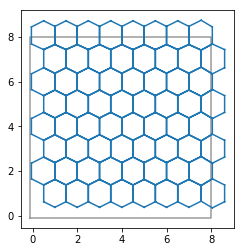

In [12]:
fig, ax = plt.subplots()

x, y = sheet.coords[:2]
srce_x = sheet.edge_df['s'+x].values
srce_y = sheet.edge_df['s'+y].values
trgt_x = sheet.edge_df['t'+x].values
trgt_y = sheet.edge_df['t'+y].values

lines_x, lines_y = np.zeros(2 * sheet.Ne), np.zeros(2 * sheet.Ne)
lines_x[::2] = srce_x
lines_x[1::2] = trgt_x
lines_y[::2] = srce_y
lines_y[1::2] = trgt_y
# Trick from https://github.com/matplotlib/
# matplotlib/blob/master/lib/matplotlib/tri/triplot.py#L65
lines_x = np.insert(lines_x, slice(None, None, 2), np.nan)
lines_y = np.insert(lines_y, slice(None, None, 2), np.nan)

(x_min, x_max), (y_min, y_max) = (sheet.settings['boundaries']['x'], 
                                  sheet.settings['boundaries']['y'])
square = (np.array([x_min, x_max, x_max, x_min, x_min]),
          np.array([y_min, y_min, y_max, y_max, y_min]))

ax.plot(square[0], square[1], 'k-', alpha=0.4)
ax.plot(lines_x, lines_y)
ax.set_aspect('equal')
